In [31]:
import numpy as np
import torch
import random

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [32]:
from preprocessing import (
    get_pages,
    get_sentences_per_page,
    get_embeddings_per_page,
)

from sentence_pairs import (
    SentencePairsClassifier,
    SentencePairsDataset,
)

In [33]:
pages = get_pages('cains_jawbone.txt')
sentences = get_sentences_per_page(pages=pages)
embeddings = get_embeddings_per_page(sentences=sentences)

In [34]:
dataset = SentencePairsDataset(embeddings=embeddings)
model = SentencePairsClassifier(layer_sizes=[768, 256, 64, 1])

In [35]:
model

SentencePairsClassifier(
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=768, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)

# Training

In [36]:
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn

In [37]:
n_epochs = 5
batch_size = 32
optim = Adam(params=model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
)

losses = []

for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1} / {n_epochs}')
    for sentences, labels in dataloader:
        optim.zero_grad()

        preds = model(sentences)
        loss = loss_fn(preds.flatten(), labels)

        loss.backward()
        optim.step()
        losses.append(loss.item())

Epoch 1 / 5
Epoch 2 / 5
Epoch 3 / 5
Epoch 4 / 5
Epoch 5 / 5


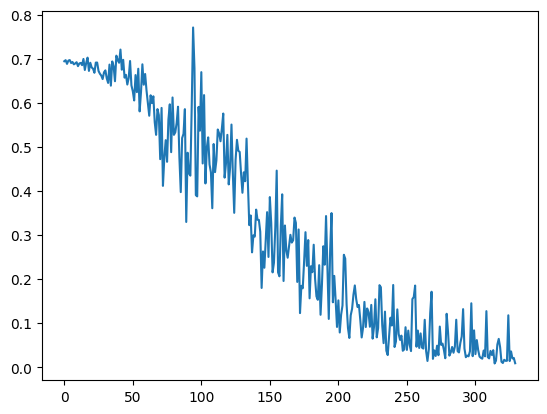

In [38]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [39]:
min(losses)

0.008986295200884342

# Inference

In [40]:
from sentence_pairs import inference

probabilities = inference(model=model, embeddings=embeddings)

/Users/thomas.buffagni/Documents/Playground/Cain-s-Jawbone/sentence_pairs.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after_page_a_probs = nn.functional.softmax(torch.tensor(after_page_a_logits))


In [41]:
max(probabilities[60].values())

0.024474544

<BarContainer object of 99 artists>

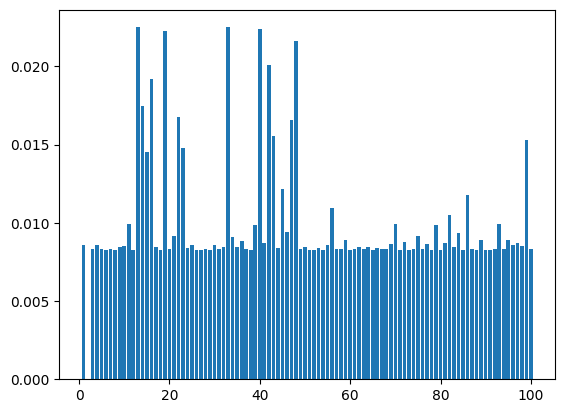

In [42]:
page_a = 2
plt.bar(probabilities[page_a].keys(), probabilities[page_a].values())

In [43]:
start_page = 1
all_pages = list(range(1, 101))
all_pages.remove(start_page)

greedy_order = [start_page]
greedy_probability = 1


while len(all_pages) > 0:
    sorted_probs = sorted(probabilities[greedy_order[-1]].items(), key=lambda x: -x[1])
    i = 0
    while sorted_probs[i][0] in greedy_order:
        i += 1

    next_page = sorted_probs[i][0]
    greedy_probability *= probabilities[greedy_order[-1]][next_page]
    greedy_order.append(next_page)
    all_pages.remove(next_page)

In [44]:
str(greedy_order)

'[1, 13, 33, 40, 22, 42, 11, 48, 19, 15, 47, 43, 45, 14, 16, 99, 21, 56, 28, 70, 23, 46, 89, 34, 95, 64, 83, 17, 59, 77, 20, 25, 97, 100, 79, 53, 36, 98, 35, 74, 75, 32, 82, 37, 93, 69, 66, 4, 9, 44, 51, 55, 92, 86, 84, 39, 10, 3, 30, 85, 76, 49, 41, 50, 31, 67, 81, 90, 91, 94, 57, 72, 52, 62, 87, 7, 71, 27, 96, 54, 12, 24, 80, 26, 58, 29, 65, 63, 5, 38, 61, 2, 68, 73, 6, 78, 8, 18, 88, 60]'

In [45]:
greedy_probability

2.1656238732743313e-194

In [95]:
from search import beam_search

best_sequence, best_prob = None, 0

for start_page in range(1, 101):
    sequence, prob = beam_search(
        start_page=start_page,
        probabilities=probabilities,
        width=100,
    )

    if prob > best_prob:
        best_sequence = sequence
        best_prob = prob

In [96]:
best_prob

1.8976901855493993e-189

In [97]:
best_sequence

[80,
 3,
 42,
 40,
 22,
 33,
 13,
 15,
 11,
 48,
 23,
 47,
 46,
 19,
 77,
 34,
 28,
 70,
 45,
 14,
 43,
 17,
 98,
 97,
 89,
 20,
 55,
 21,
 36,
 83,
 16,
 49,
 10,
 35,
 95,
 81,
 39,
 93,
 59,
 92,
 86,
 8,
 69,
 79,
 53,
 41,
 9,
 44,
 100,
 66,
 25,
 73,
 4,
 2,
 99,
 38,
 1,
 18,
 32,
 82,
 6,
 27,
 30,
 58,
 7,
 57,
 64,
 91,
 74,
 75,
 54,
 62,
 56,
 37,
 78,
 88,
 65,
 60,
 24,
 87,
 68,
 67,
 52,
 72,
 85,
 84,
 50,
 31,
 76,
 94,
 26,
 5,
 63,
 71,
 96,
 12,
 61,
 90,
 29,
 51]